In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [3]:
def softmax(x):
    # subtract max value to prevent overflow
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [5]:
n_particles = 5
k = 7
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
ses = []

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx, (user_id, item_id, rating, ts) in enumerate(datapoints):

    pred_rating = np.mean([np.dot(particle[1]["u"][user_id, :], particle[1]["v"][item_id, :]) for particle in particles])
    errors = pred_rating - rating
    se = np.sum(errors ** 2)
    if _idx % 101 == 0:
        ses.append(se)
    if _idx % 1001 == 0:
        print("squared error: {:.2f}".format(se))

    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * \
                np.dot(v_j.T, v_j) + \
                1 / particle[1]["var_u"] * np.eye(k)

            precision_u_i.append(lambda_u_i)

            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))

    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)

    # line 19
    ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
    p_prime = [{"u": np.copy(particles[d][1]["u"]),
                "v": np.copy(particles[d][1]["v"]),
                "var_u": particles[d][1]["var_u"],
                "var_i": particles[d][1]["var_i"]} for d in ds]
    for idx, (particle, precision, e) in enumerate(zip(p_prime, precision_u_i, eta_u_i)):

        # line 21
        v_j = particle["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision

        add_to_eta = rating * v_j
        e += add_to_eta

        # line 22
        p_prime[idx]["u"][user_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )

        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle["var_i"] * np.eye(k)

            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        p_prime[idx]["v"][item_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )

    # line 28
    particles = [(1 / n_particles, particle) for particle in p_prime]

    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

squared error: 27.18
squared error: 0.28
squared error: 67.14
squared error: 0.09
squared error: 6.71
squared error: 30.03
squared error: 33.01
squared error: 8.86
squared error: 0.11
squared error: 4.84
squared error: 0.96
squared error: 0.33
squared error: 0.50
squared error: 6.42
squared error: 2.86
squared error: 0.57
squared error: 6.39
squared error: 1.25
squared error: 0.50
squared error: 0.05
squared error: 0.07
squared error: 1.73
squared error: 0.05
squared error: 0.09
squared error: 43.17
squared error: 0.71
squared error: 5.86
squared error: 0.33
squared error: 0.08
squared error: 0.29
squared error: 0.15
squared error: 3.66
squared error: 0.73
squared error: 0.36
squared error: 0.55
squared error: 0.82
squared error: 0.19
squared error: 10.84
squared error: 1.04
squared error: 2.67
squared error: 4.28
squared error: 1.02
squared error: 9.55
squared error: 0.74
squared error: 0.10
squared error: 10.23
squared error: 0.04
squared error: 0.10
squared error: 0.05
squared error

In [6]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


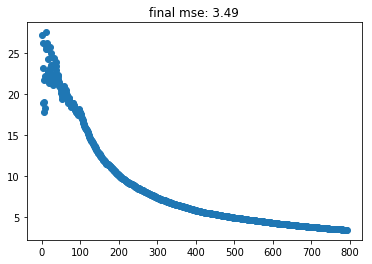

In [7]:
mses = moving_average(ses)
plt.scatter(range(len(mses)), mses)
plt.title("final mse: {:.2f}".format(mses[-1]))
plt.show()